In [17]:
import yfinance as yf
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
df = yf.download('AAPL', start='2022-01-10', end='2023-01-10')

[*********************100%%**********************]  1 of 1 completed


In [19]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-10,169.080002,172.500000,168.169998,172.190002,170.244858,106765600
2022-01-11,172.320007,175.179993,170.820007,175.080002,173.102188,76138300
2022-01-12,176.119995,177.179993,174.820007,175.529999,173.547089,74805200
2022-01-13,175.779999,176.619995,171.789993,172.190002,170.244858,84505800
2022-01-14,171.339996,173.779999,171.089996,173.070007,171.114899,80440800


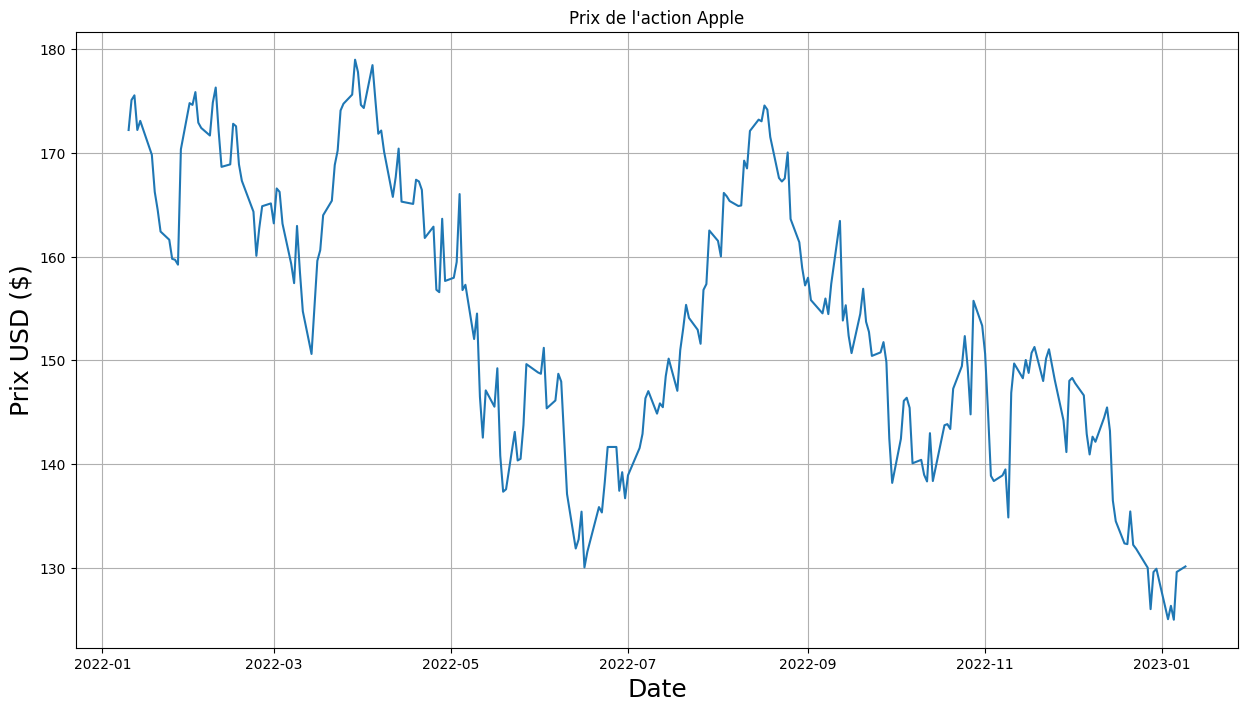

In [20]:
plt.figure(figsize=(15, 8))
plt.title('Prix de l\'action Apple')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix USD ($)', fontsize=18)
plt.grid()
plt.show()

In [21]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values) * .8)

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

## Training Data

In [23]:
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Test Data

In [24]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

## LSTM Model

In [25]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
141/141 [==============================] - 10s 33ms/step - loss: 0.0253
Epoch 2/10
141/141 [==============================] - 5s 33ms/step - loss: 0.0089
Epoch 3/10
141/141 [==============================] - 5s 33ms/step - loss: 0.0090
Epoch 4/10
141/141 [==============================] - 5s 33ms/step - loss: 0.0095
Epoch 5/10
141/141 [==============================] - 5s 34ms/step - loss: 0.0076
Epoch 6/10
141/141 [==============================] - 5s 34ms/step - loss: 0.0067
Epoch 7/10
141/141 [==============================] - 5s 33ms/step - loss: 0.0073
Epoch 8/10
141/141 [==============================] - 4s 30ms/step - loss: 0.0056
Epoch 9/10
141/141 [==============================] - 4s 29ms/step - loss: 0.0058
Epoch 10/10
141/141 [==============================] - 4s 30ms/step - loss: 0.0059


## Prediction

In [27]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 1s 24ms/step


1.7883198547363282

## Graph

In [28]:
data = df.filter(['Close'])
train = data[:training_data_len]
validations = data[training_data_len:]
validations['Predictions'] = predictions

C:\Users\oussa.000\AppData\Local\Temp\ipykernel_5216\1907379856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validations['Predictions'] = predictions


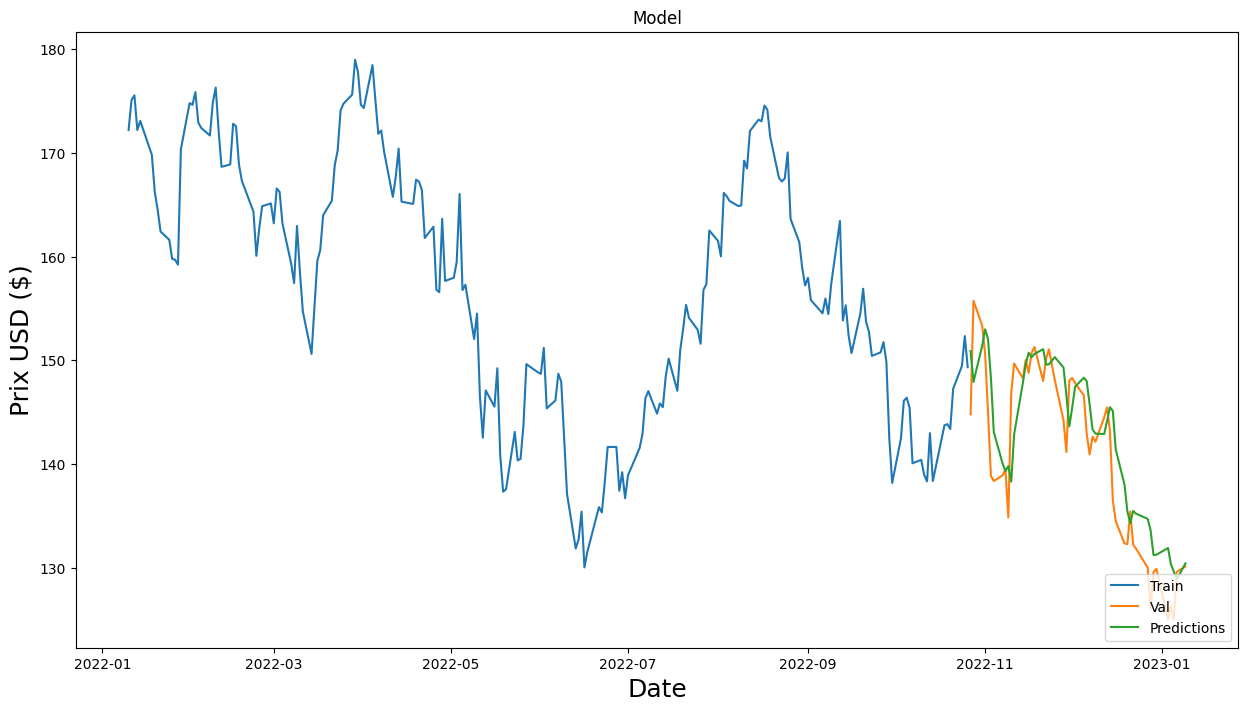

In [29]:
plt.figure(figsize=(15, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix USD ($)', fontsize=18)
plt.plot(train)
plt.plot(validations[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()